In [1]:
import pandas as pd
from text_mining.utils import annotate_texts, analyze_with_vader, krippendorff_analysis, train_classifier, preprocess_tweets, analyze_with_transformer
from text_mining.data import load_excel_annotations, load_sentiment_dict

/home/krasky/dev/social_data_mining/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/krasky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/krasky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/krasky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df_train = load_excel_annotations("../../../../data/train.xlsx")
df_train["train"] = True
df_test = load_excel_annotations("../../../../data/test.xlsx")
df_test["train"] = False

df = pd.concat([df_train, df_test])
print(df.info())
print(f"train len = {len(df_train)}, test len = {len(df_test)}")

subset_nas = ["CODE", "TEXT"]
print(f"train len no na = {len(df_train.dropna(subset=subset_nas))}, test len no na = {len(df_test.dropna(subset=subset_nas))}")
df = df.dropna(subset=subset_nas, ignore_index=True)
print("---No NAs info---")
print(df.info())
print("\n--SANITY CHECK--")
print(f"unqique text len = {len(df["TEXT"].unique())} ==? {len(df)} (df len)")

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             6000 non-null   int64  
 1   CODE           189 non-null    float64
 2   TEXT           6000 non-null   object 
 3   coder          6000 non-null   int64  
 4   gpt_sentiment  975 non-null    float64
 5   train          6000 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(1)
memory usage: 287.1+ KB
None
train len = 5000, test len = 1000
train len no na = 108, test len no na = 81
---No NAs info---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             189 non-null    int64  
 1   CODE           189 non-null    float64
 2   TEXT           189 non-null    object 
 3   coder          189 non-null    int64  
 4   gp

## 2.1  **Own Dictionary**
   - Use a custom dictionary for tweet annotation.

In [3]:
annotations = annotate_texts(
    df["TEXT"].tolist(),
    sentiment_dict_path="../../../../data/COPSSentimentDict.csv"
    )
df["dict_sentiment"] = annotations
df["dict_sentiment_rounded"] = [round(annotation) for annotation in annotations]
# print(df["dict_sentiment_rounded"].unique())
df.describe()

,ID,CODE,coder,gpt_sentiment,dict_sentiment,dict_sentiment_rounded
count,1.890000e+02,189.000000,189.0,81.000000,189.000000,189.000000
mean,6.737459e+17,0.248677,1.0,0.370370,0.112875,0.116402
std,1.797108e+15,0.755519,0.0,0.781736,0.624771,0.607748
min,6.721652e+17,-1.000000,1.0,-1.000000,-1.000000,-1.000000
25%,6.721886e+17,0.000000,1.0,0.000000,0.000000,0.000000
50%,6.722204e+17,0.000000,1.0,1.000000,0.000000,0.000000
75%,6.758148e+17,1.000000,1.0,1.000000,0.500000,0.000000
max,6.758268e+17,1.000000,1.0,1.000000,1.000000,1.000000


In [4]:
krippendorff_analysis(
    df[["CODE", "dict_sentiment"]].to_numpy(),
    method_names=["human", "our dict"]
)
print("\n -- ROUNDED")
krippendorff_analysis(
    df[["CODE", "dict_sentiment_rounded"]].to_numpy(),
    method_names=["human", "our dict rounded"]
)

Krippendorff's Alpha: 0.1194
The methods show poor agreement.

Method-wise Agreement Summary:

human comparison with other methods:
  'human' vs. 'our dict': 31.75% agreement

our dict comparison with other methods:
  'our dict' vs. 'human': 31.75% agreement

 -- ROUNDED
Krippendorff's Alpha: 0.0907
The methods show poor agreement.

Method-wise Agreement Summary:

human comparison with other methods:
  'human' vs. 'our dict rounded': 38.62% agreement

our dict rounded comparison with other methods:
  'our dict rounded' vs. 'human': 38.62% agreement


## **2.2: VADER**
   - Employ VADER for sentiment analysis.


In [5]:
v_annotations = analyze_with_vader(df["TEXT"].tolist())
df["v_sentiment"] = v_annotations
df["v_sentiment_rounded"] = [round(a) for a in v_annotations]
df[["v_sentiment", "v_sentiment_rounded", "CODE"]].sample(10).head()

,v_sentiment,v_sentiment_rounded,CODE
47,0.2960,0,0.0
28,0.0000,0,0.0
19,0.4310,0,-1.0
180,0.0000,0,0.0
38,0.4019,0,1.0


In [6]:
krippendorff_analysis(
    df[["CODE", "v_sentiment"]].to_numpy(),
    method_names=["human", "vader"]
)
print("\n---ROUNDED---")
krippendorff_analysis(
    df[["CODE", "v_sentiment_rounded"]].to_numpy(),
    method_names=["human", "vader rounded"]
)

Krippendorff's Alpha: 0.3590
The methods show poor agreement.

Method-wise Agreement Summary:

human comparison with other methods:
  'human' vs. 'vader': 20.63% agreement

vader comparison with other methods:
  'vader' vs. 'human': 20.63% agreement

---ROUNDED---
Krippendorff's Alpha: 0.3303
The methods show poor agreement.

Method-wise Agreement Summary:

human comparison with other methods:
  'human' vs. 'vader rounded': 53.44% agreement

vader rounded comparison with other methods:
  'vader rounded' vs. 'human': 53.44% agreement


## 2.3: Machine Learning
   - Train a classifier (**Naive Bayes**) using bag-of-words features.

In [7]:
classifer, vectorizer = train_classifier(df["TEXT"].tolist(), labels=df["CODE"])
ml_annotations = classifer.predict(vectorizer.transform(preprocess_tweets(df["TEXT"])))
df["ml_sentiment"] = ml_annotations
df[["CODE", "ml_sentiment"]].sample(10).head()

Classification Rep:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         8
         0.0       0.44      0.70      0.54        10
         1.0       0.77      0.85      0.81        20

    accuracy                           0.63        38
   macro avg       0.40      0.52      0.45        38
weighted avg       0.52      0.63      0.57        38



/home/krasky/dev/social_data_mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/krasky/dev/social_data_mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/krasky/dev/social_data_mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

,CODE,ml_sentiment
152,1.0,1.0
39,1.0,1.0
78,1.0,0.0
162,1.0,1.0
151,1.0,1.0


In [8]:
krippendorff_analysis(
    df[["CODE", "ml_sentiment"]].to_numpy(),
    method_names=["Human", "ML"]
) # NOTE duh the methods show strong agreement

Krippendorff's Alpha: 0.9084
The methods show strong agreement.

Method-wise Agreement Summary:

Human comparison with other methods:
  'Human' vs. 'ML': 92.59% agreement

ML comparison with other methods:
  'ML' vs. 'Human': 92.59% agreement


## 2.4: Transformer Model
   - Apply a fine-tuned transformer model for sentiment analysis.
   - distilbert/distilbert-base-uncased-finetuned-sst-2-english
      - FINE TUNED ON: "The authors use the following Stanford Sentiment Treebank(sst2) corpora for the model."

In [9]:
llm_annotations = analyze_with_transformer(df["TEXT"].tolist())
df["llm_sentiment"] = llm_annotations
df["llm_sentiment_rounded"] = [round(s) for s in llm_annotations]
df[["CODE", "llm_sentiment", "llm_sentiment_rounded", "TEXT"]].sample(10)
# info: distilbert/distilbert-base-uncased-finetuned-sst-2-english

Device set to use cuda:0


,CODE,llm_sentiment,llm_sentiment_rounded,TEXT
40,1.0,-0.998583,-1,"#COP21 to stop and reverse #climatechange, is ..."
47,0.0,-0.984413,-1,Editorial: @Stanford and others should join @U...
78,1.0,-0.997075,-1,@TurnbullMalcolm @GregHuntMP #HumanRights no...
177,1.0,0.965074,1,Bye Bye #COP21! #lastselfie von @DieMaus im Pl...
12,0.0,-0.995664,-1,March in a #ClimateMarch on Nov 29? Think marc...
19,-1.0,-0.983257,-1,What are all the things climate change can't d...
175,0.0,-0.999503,-1,"mashable: ""All of us had to solve it together,..."
46,1.0,-0.748484,-1,#Paris #Climate Talks: 21st Time Must Be the C...
138,0.0,0.991738,1,Paris optimism: #COP21 An economic catalyst fo...
127,0.0,-0.976484,-1,[CMP] Conference of the Parties serving as the...


In [10]:
krippendorff_analysis(
    df[["CODE", "llm_sentiment"]],
    method_names=["human", "llm sentiment"]
)
print("\n---ROUNDED---")
krippendorff_analysis(
    df[["CODE", "llm_sentiment_rounded"]],
    method_names=["human", "llm rounded"]
)

Krippendorff's Alpha: 0.1666
The methods show poor agreement.

Method-wise Agreement Summary:

human comparison with other methods:
  'human' vs. 'llm sentiment': 0.00% agreement

llm sentiment comparison with other methods:
  'llm sentiment' vs. 'human': 0.00% agreement

---ROUNDED---
Krippendorff's Alpha: 0.0401
The methods show poor agreement.

Method-wise Agreement Summary:

human comparison with other methods:
  'human' vs. 'llm rounded': 34.39% agreement

llm rounded comparison with other methods:
  'llm rounded' vs. 'human': 34.39% agreement


## 2.5: Comparison
   - Compare all approaches using test and unlabelled data.
   - Optional: Fine-tune a transformer on training data.

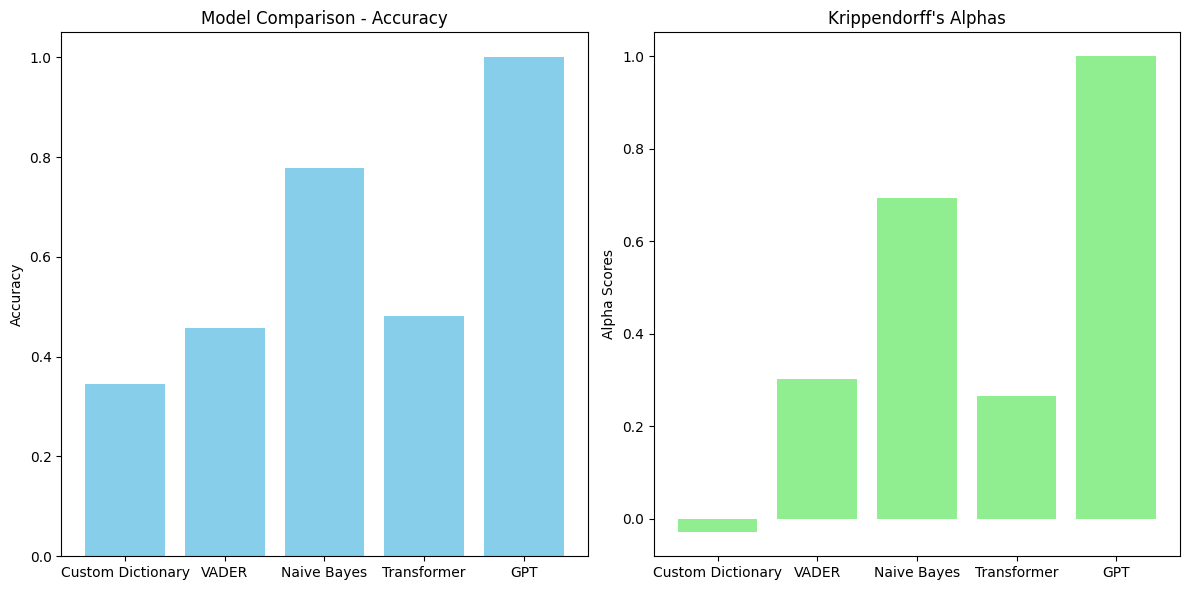

In [11]:
def plot_comparisons(dataframe: pd.DataFrame, sentiment_columns: list = None, method_labels: list = None):
    import matplotlib.pyplot as plt
    from sklearn.metrics import accuracy_score
    import krippendorff
    import numpy as np

    if sentiment_columns is None:
        sentiment_columns = [
            "dict_sentiment_rounded", "v_sentiment_rounded",
            "ml_sentiment", "llm_sentiment_rounded", "gpt_sentiment"
            ]
    if method_labels is None:
        method_labels = sentiment_columns

    accuracies = []
    alphas = []

    # True labels are gpt_sentiment
    true_labels = dataframe["gpt_sentiment"].tolist()

    for sentiment_column in sentiment_columns:
        predictions = dataframe[sentiment_column].tolist()
        accuracy = accuracy_score(true_labels, predictions)
        accuracies.append(accuracy)

        alpha = krippendorff.alpha(reliability_data=np.array([true_labels, predictions]), level_of_measurement="ordinal")
        alphas.append(alpha)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.bar(method_labels, accuracies, color="skyblue")
    ax1.set_title("Model Comparison - Accuracy")
    ax1.set_ylabel("Accuracy")

    ax2.bar(method_labels, alphas, color="lightgreen")
    ax2.set_title("Krippendorff's Alphas")
    ax2.set_ylabel("Alpha Scores")

    plt.tight_layout()
    plt.show()

sentiment_columns = [
    "dict_sentiment_rounded", "v_sentiment_rounded",
    "ml_sentiment", "llm_sentiment_rounded", "gpt_sentiment"
]
method_labels = ["Custom Dictionary", "VADER", "Naive Bayes", "Transformer", "GPT"]
df_no_nas = df.dropna(subset="gpt_sentiment")

plot_comparisons(df_no_nas, sentiment_columns=sentiment_columns, method_labels=method_labels)

### Best model: ML (Naive Bayes) classifier
Train final model on all data.

In [12]:
cls_final, vectorizer = train_classifier(df["TEXT"].tolist(), labels=df["CODE"], test_size=0.02)
processed_data = ml_annotations = cls_final.predict(vectorizer.transform(preprocess_tweets(df["TEXT"])))
df["ml_sentiment_final"] = ml_annotations
df[["CODE", "ml_sentiment_final", "gpt_sentiment", "TEXT"]].sample(10)

Classification Rep:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



,CODE,ml_sentiment_final,gpt_sentiment,TEXT
169,-1.0,-1.0,-1.0,People (and especially leaders) need to stop o...
12,0.0,0.0,NaN,March in a #ClimateMarch on Nov 29? Think marc...
171,0.0,0.0,0.0,Good analysis .. Judging the #COP21 outcome an...
146,-1.0,-1.0,-1.0,#YOUNGO youth decalaration: this agreement is ...
170,1.0,1.0,1.0,"Just when you start to lose faith in humanity,..."
113,-1.0,-1.0,0.0,Retweeted Agence France-Presse (@AFP): Scient...
0,-1.0,-1.0,NaN,Piece for @TheWorldPost: 2 wars connected by c...
75,0.0,0.0,NaN,Tomorrow is #BuildingsDay at #COP21. Backgroun...
117,1.0,1.0,1.0,Serendipity of #COP21 agreement on same day as...
28,0.0,0.0,NaN,Drs letter to @JustinTrudeau 2/5: Adopt..ambit...


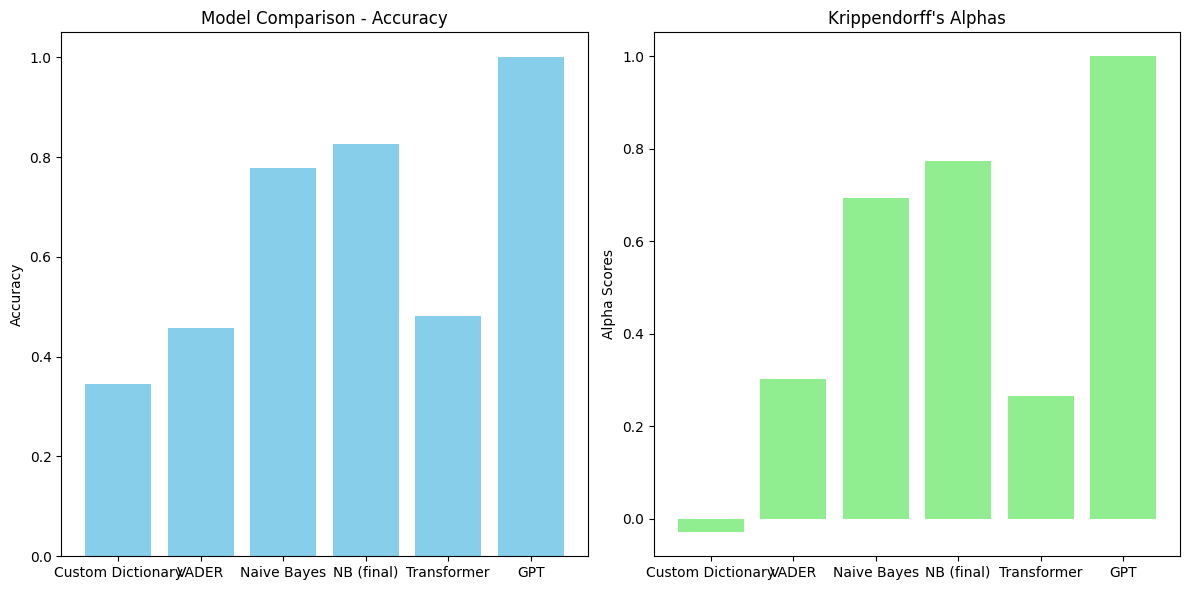

In [13]:
sentiment_columns = [
    "dict_sentiment_rounded", "v_sentiment_rounded", "ml_sentiment", "ml_sentiment_final", "llm_sentiment_rounded", "gpt_sentiment"
]
method_labels = ["Custom Dictionary", "VADER", "Naive Bayes", "NB (final)", "Transformer", "GPT"]
df_no_nas = df.dropna(subset="gpt_sentiment")

plot_comparisons(df_no_nas, sentiment_columns=sentiment_columns, method_labels=method_labels)
# df.info()
# df["dict_sentiment"].unique()

In [14]:
# test kripp walk
temp = [
    [1, 1],  # Tweet 1: All methods agree on 'positive'
    [0, 0],  # Tweet 2: All methods agree on 'neutral'
    [-1, -1],  # Tweet 3: All methods agree on 'negative'
    [1, 1],  # Tweet 4: All methods agree on 'positive'
    [0, 0],  # Tweet 5: All methods agree on 'neutral'
]
krippendorff_analysis(temp, method_names=[f"{i}" for i in range(len(temp[0]))])

Krippendorff's Alpha: 1.0000
The methods show strong agreement.

Method-wise Agreement Summary:

0 comparison with other methods:
  '0' vs. '1': 100.00% agreement

1 comparison with other methods:
  '1' vs. '0': 100.00% agreement
